# DATA EXPLORATION FOR THE ZENDRIVE SCHEMA

In this notebook we explore the zendrive schema and its tables to understand the data model and the information collected. Tables explored are:

1. `zendrive.users`
2. `zendrive.trip`
3. `zendrive.event`
4. `zendrive.path_point`

We do not cover the exploration of `zendrive.trip_discount_total`(for now) as it contains information relating to the aggregation of user scores for discount computation purposes


In [1]:
import pandas as pd
import psycopg2, os
import matplotlib.pyplot as plt

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

---

## 1. Users table

The users table contains info on the users of the app

In [2]:
cur.execute("SELECT * FROM zendrive.user")
users = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
users.head(2)


,id,cep,created_at,updated_at,score,distance,last_trip_date,user_composed_id,email,internal_timestamp
0,958,08246-080,2021-07-07 08:44:50.880449,2021-10-04 06:56:21.336009,74.0,132.64,2021-08-02 07:21:13,958--2021-10-04 06:56:21.336009,clovisfrancisco1302@gmail.com,2021-10-04 12:25:57.645986
1,728,None,2021-07-03 12:33:39.878525,2021-10-03 17:46:52.278133,0.0,0.00,NaT,728--2021-10-03 17:46:52.278133,erivanda553@gmail.com,2021-10-04 12:25:57.645986


We find user level duplicates

In [3]:
print('Rows in table:', users.shape[0])
print('Unique user IDs:', users.id.nunique())


Rows in table: 129131
Unique user IDs: 17789


Query user with most entries

In [4]:
user_of_interest = users.groupby('id').apply(lambda x: x.shape[0]).sort_values(ascending=False).index[0]
user_entries = users[users['id']==user_of_interest].copy()
print(f"User with most entries has id {user_of_interest} and {user_entries.shape[0]} records")
user_entries.head()


User with most entries has id 4328 and 705 records


,id,cep,created_at,updated_at,score,distance,last_trip_date,user_composed_id,email,internal_timestamp
124,4328,None,2021-08-06 21:29:52.385752,2021-10-04 12:08:12.608730,70.0,249.43,2021-08-09 11:27:10,4328--2021-10-04 12:08:12.60873,sid_jeane@hotmail.com,2021-10-04 12:25:57.645986
569,4328,None,2021-08-06 21:29:52.385752,2021-10-04 13:24:57.824865,70.0,249.43,2021-08-09 11:27:10,4328--2021-10-04 13:24:57.824865,sid_jeane@hotmail.com,2021-10-04 13:46:32.293119
617,4328,None,2021-08-06 21:29:52.385752,2021-10-12 21:19:09.755388,70.0,249.43,2021-08-09 11:27:10,4328--2021-10-12 21:19:09.755388,sid_jeane@hotmail.com,2021-10-12 21:46:46.221088
627,4328,None,2021-08-06 21:29:52.385752,2021-10-04 14:15:42.205540,70.0,249.43,2021-08-09 11:27:10,4328--2021-10-04 14:15:42.20554,sid_jeane@hotmail.com,2021-10-04 14:46:26.593925
684,4328,None,2021-08-06 21:29:52.385752,2021-10-04 15:16:07.149808,70.0,249.43,2021-08-09 11:27:10,4328--2021-10-04 15:16:07.149808,sid_jeane@hotmail.com,2021-10-04 15:47:12.376766


The only difference between rows is the columns that involve an update timestamp

In [5]:
user_entries.apply(lambda x: x.nunique())

id                      1
cep                     0
created_at              1
updated_at            705
score                   1
distance                1
last_trip_date          1
user_composed_id      705
email                   1
internal_timestamp    682
dtype: int64

Check if this is true for all users - it is not, so pick the user with the biggest amount of unique values across columns

In [6]:
unique_values_count = users.drop(columns=['updated_at', 
                                          'user_composed_id', 
                                          'internal_timestamp']).drop_duplicates().groupby('id').apply(lambda x: x.nunique())

user_of_interest = unique_values_count.sum(axis=1).sort_values(ascending=False).index[0]
user_entries = users[users['id']==user_of_interest].copy()
user_entries.head()



,id,cep,created_at,updated_at,score,distance,last_trip_date,user_composed_id,email,internal_timestamp
327,533,09030-400,2021-06-27 20:08:14.780,2021-10-02 17:07:02.674836,95.0,1357.999,2021-10-01 19:43:53,533--2021-10-02 17:07:02.674836,rafael.avl@me.com,2021-10-04 12:25:57.645986
554,533,09030-400,2021-06-27 20:08:14.780,2021-10-09 21:46:24.664537,95.0,1390.423,2021-10-08 11:13:32,533--2021-10-09 21:46:24.664537,rafael.avl@me.com,2021-10-09 22:46:53.400199
1076,533,09030-400,2021-06-27 20:08:14.780,2021-10-09 23:59:45.274922,95.0,1390.423,2021-10-09 16:57:52,533--2021-10-09 23:59:45.274922,rafael.avl@me.com,2021-10-10 00:47:02.089846
1331,533,09030-400,2021-06-27 20:08:14.780,2021-10-10 01:42:48.204239,95.0,1392.154,2021-10-09 16:57:52,533--2021-10-10 01:42:48.204239,rafael.avl@me.com,2021-10-10 02:46:56.549393
2094,533,09030-400,2021-06-27 20:08:14.780,2021-10-10 13:02:48.714420,95.0,1392.154,2021-10-09 23:43:37,533--2021-10-10 13:02:48.71442,rafael.avl@me.com,2021-10-10 13:46:52.351268


DIstance should increase with timestamp

<AxesSubplot:xlabel='updated_at', ylabel='score'>

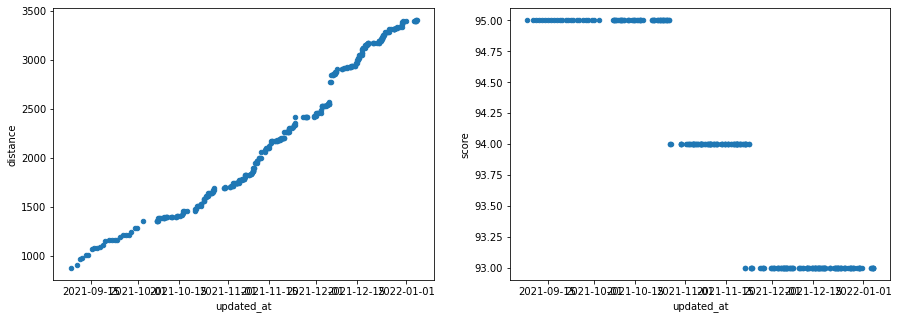

In [7]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
user_entries.plot(kind='scatter', x='updated_at', y='distance', ax=axes[0])
user_entries.plot(kind='scatter', x='updated_at', y='score', ax=axes[1])

Main learnings are:

- This stores cumulative informatio on users of the app
- When a new trip happens, the table (supposedly) updates creating a new record for the user
- In the record a few fields will be fixed:
    - `id`: Unique user id
    - `cep`: User CEP code
    - `created_at`: Time at which the user registered
    - `email`
- The rest of the fields should update with information of the latest trip, including:
    - `updated_at`
    - `score`
    - `distance`: Cumulative user distance (see scatterplot above)
    - `last_trip_date`
    
---

## 2. Trip table

The trip table

In [118]:
cur.execute("SELECT * FROM zendrive.trip")
trips = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
trips.head(2)


,id,trip_id,driver,created_at,updated_at,started_at,ended_at,distance,score,user_feedback,...,longitude_end,hard_turn_rating,phone_use_rating,hard_brake_rating,overspeeding_rating,rapid_acceleration_rating,drive_type,vehicle_type,trip_composed_id,internal_timestamp
0,162224,1630920223676,963,2021-09-06 10:08:34.593644,2021-09-08 05:01:11.653504,2021-09-06 09:23:43,2021-09-06 09:33:55,3.036,100.0,None,...,-39.532036,-1,-1,5,5,5,driver,car,162224--2021-09-08 05:01:11.653504,2021-10-04 15:53:48.478772
1,162179,1630916816151,963,2021-09-06 08:44:37.182426,2021-09-08 05:01:14.697874,2021-09-06 08:26:56,2021-09-06 08:36:47,0.830,100.0,None,...,-39.530622,-1,-1,5,5,5,driver,car,162179--2021-09-08 05:01:14.697874,2021-10-04 15:53:48.478772


---

### 2.1. Analysis of the dataframe

Some analysis of the columns in the df

#### ID INFO

In [119]:
trips[['id', 'trip_id', 'driver', 'drive_type', 'vehicle_type']].head()

,id,trip_id,driver,drive_type,vehicle_type
0,162224,1630920223676,963,driver,car
1,162179,1630916816151,963,driver,car
2,162174,1630916110781,963,driver,car
3,162129,1630898927245,963,driver,car
4,7,1619340142907,13,driver,car


#### RECORD TIMESTAMPS

In [120]:
trips[['created_at', 'updated_at', 'internal_timestamp', 'trip_composed_id']].head()

,created_at,updated_at,internal_timestamp,trip_composed_id
0,2021-09-06 10:08:34.593644,2021-09-08 05:01:11.653504,2021-10-04 15:53:48.478772,162224--2021-09-08 05:01:11.653504
1,2021-09-06 08:44:37.182426,2021-09-08 05:01:14.697874,2021-10-04 15:53:48.478772,162179--2021-09-08 05:01:14.697874
2,2021-09-06 08:27:11.414375,2021-09-08 05:01:18.592458,2021-10-04 15:53:48.478772,162174--2021-09-08 05:01:18.592458
3,2021-09-06 03:47:20.740561,2021-09-08 05:01:47.194111,2021-10-04 15:53:48.478772,162129--2021-09-08 05:01:47.194111
4,2021-05-27 09:30:19.683158,2021-06-18 13:42:39.432033,2021-10-04 15:53:48.478772,7--2021-06-18 13:42:39.432033


#### TRIP START AND END

In [121]:
trips[['started_at', 'latitude_start', 'longitude_start', 
       'ended_at', 'latitude_end', 'longitude_end']].head()

,started_at,latitude_start,longitude_start,ended_at,latitude_end,longitude_end
0,2021-09-06 09:23:43,-18.058348,-39.534217,2021-09-06 09:33:55,-18.057699,-39.532036
1,2021-09-06 08:26:56,-18.057912,-39.532524,2021-09-06 08:36:47,-18.055221,-39.530622
2,2021-09-06 08:15:10,-18.055610,-39.532735,2021-09-06 08:20:25,-18.057705,-39.532039
3,2021-09-06 03:28:47,-18.053549,-39.529428,2021-09-06 03:39:11,-18.057814,-39.532116
4,2021-04-25 08:42:22,37.912951,-4.881221,2021-04-25 08:47:00,37.911233,-4.874953


#### TRIP INFO

In [122]:
trips[['distance', 'duration_seconds', 'trip_max_speed_kmph', 'user_feedback']].head()

,distance,duration_seconds,trip_max_speed_kmph,user_feedback
0,3.036,611.501,33.019836,None
1,0.830,591.594,19.713024,None
2,0.912,314.899,19.996103,None
3,1.494,624.371,14.328577,None
4,0.908,278.000,18.443468,None


#### SCORES

In [123]:
trips[['score', 'hard_turn_rating', 'phone_use_rating',
       'hard_brake_rating', 'overspeeding_rating', 'rapid_acceleration_rating']].head()

,score,hard_turn_rating,phone_use_rating,hard_brake_rating,overspeeding_rating,rapid_acceleration_rating
0,100.0,-1,-1,5,5,5
1,100.0,-1,-1,5,5,5
2,100.0,-1,-1,5,5,5
3,100.0,-1,-1,5,5,5
4,100.0,5,5,5,5,5


### 2.2. Sanity checks

Let's check the consistency between `zendrive.user` and `zendrive.trip`

#### SANITY CHECK 1

We should have that there's no trips made by users not registered in the user table

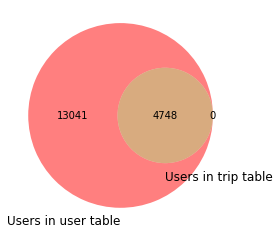

In [96]:
from matplotlib_venn import venn2
venn2(subsets = (len(set(users.id)-set(trips.driver)),
                 len(set(trips.driver)-set(users.id)), 
                 len(set(trips.driver).intersection(set(users.id)))),
      set_labels = ('Users in user table', 'Users in trip table'),
      alpha = 0.5)
plt.show()


Good - all trips have driver id's registered in the users table. 

#### SANITY CHECK 2

The two following sets should be the same:
1. Users in the user table that have a total distance >0
2. The users in the trip table that have at least 1 trip where they said they were driving



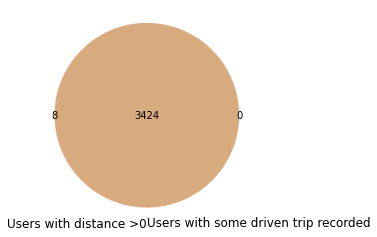

In [97]:
set1 = set(users[users['distance']>0].id)
set2 = set(trips[(trips['drive_type']=='driver') &
                 (trips['distance']>0)].driver)

venn2(subsets = (len(set1-set2),
                 len(set2-set1), 
                 len(set1.intersection(set2))),
      set_labels = ('Users with distance >0', 'Users with some driven trip recorded'),
      alpha = 0.5)
plt.show()


It seems we only have a couple of exceptions, 8 drivers with no trips recorded... but they all seem to have very recent update dates so probably it's just the two table slightly out of sync

In [98]:
for driver_id in set1-set2:
    display(users[users['id']==driver_id].last_trip_date.min())


Timestamp('2022-01-03 21:34:05')

Timestamp('2022-01-03 21:59:20')

Timestamp('2022-01-04 01:23:00')

Timestamp('2022-01-04 12:20:18')

Timestamp('2022-01-02 21:26:26')

Timestamp('2022-01-03 20:37:20')

Timestamp('2022-01-03 22:14:32')

NaT

#### SANITY CHECK 3

Let's try and replicate the distances in the user table from the trip table

In [99]:
dt = users.sort_values('updated_at', ascending=False).groupby('id').head(1).merge(
    pd.DataFrame(trips[trips['drive_type']=='driver'].groupby('driver').distance.sum()).reset_index().rename(columns={'driver': 'id', 'distance': 'computed_distance'}),
    on='id',
    how='left')[['id', 'distance', 'computed_distance']]
dt['dif'] = dt['computed_distance']-dt['distance']
dt.fillna(0, inplace=True)
display(dt.head())
print(f"Distance replicated for {dt[dt['dif'].abs()<0.001].shape[0]} out of {dt.shape[0]} users")


,id,distance,computed_distance,dif
0,16814,38.148,38.148,0.0
1,16861,58.488,58.488,0.0
2,13031,67.270,67.270,0.0
3,3955,1654.988,1654.988,0.0
4,15485,44.368,44.368,0.0


Distance replicated for 17567 out of 17789 users


For a few users distance is not correctly replicated (222) cases, and for this the median deviation is 8% of the total distance

count    222.000000
mean       0.188337
std        0.253501
min        0.000115
25%        0.019109
50%        0.081362
75%        0.253883
max        1.000000
Name: perc_dif, dtype: float64

<AxesSubplot:>

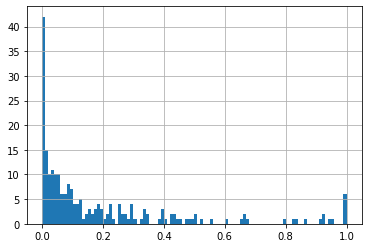

In [100]:
dt = dt[dt['dif'].abs()>0.001].copy()
dt['perc_dif']=(dt['dif']/dt['distance']).abs()
display(dt.perc_dif.describe())
dt.perc_dif.hist(bins=100)


In [8]:
cur.execute("SELECT * FROM zendrive.event")
events = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
events.head()


,trip_internal_id,trip_id,event_order_id,start_time,end_time,latitude_start,latitude_end,longitude_start,longitude_end,event_type,trip_created_at,trip_updated_at,event_type_name,event_composed_id,internal_timestamp
0,63594,1627775339065,1,2021-07-31 20:49:24,2021-07-31 20:50:05,-23.505548,-23.505982,-46.408264,-46.405889,2,2021-07-31 23:59:21,2021-07-31 23:59:21,phone_use,63594--1--2021-07-31 23:59:21,2021-10-04 15:54:50.945835
1,63594,1627775339065,2,2021-07-31 20:51:14,2021-07-31 20:51:58,-23.506560,-23.507024,-46.403251,-46.400452,2,2021-07-31 23:59:21,2021-07-31 23:59:21,phone_use,63594--2--2021-07-31 23:59:21,2021-10-04 15:54:50.945835
2,63594,1627775339065,3,2021-07-31 20:56:11,2021-07-31 20:56:11,-23.496925,-23.496925,-46.393820,-46.393820,1,2021-07-31 23:59:21,2021-07-31 23:59:21,rapid_acceleration,63594--3--2021-07-31 23:59:21,2021-10-04 15:54:50.945835
3,164621,1631021322296,1,2021-09-07 10:28:43,2021-09-07 10:28:43,-12.822128,-12.822128,-38.262796,-38.262796,0,2021-09-07 13:48:05,2021-09-07 13:48:05,hard_brake,164621--1--2021-09-07 13:48:04.513164,2021-10-04 15:54:50.945835
4,164621,1631021322296,2,2021-09-07 10:29:31,2021-09-07 10:29:31,-12.822601,-12.822601,-38.263613,-38.263613,1,2021-09-07 13:48:05,2021-09-07 13:48:05,rapid_acceleration,164621--2--2021-09-07 13:48:04.513164,2021-10-04 15:54:50.945835


,id,trip_id,driver,created_at,updated_at,started_at,ended_at,distance,score,user_feedback,...,longitude_end,hard_turn_rating,phone_use_rating,hard_brake_rating,overspeeding_rating,rapid_acceleration_rating,drive_type,vehicle_type,trip_composed_id,internal_timestamp
0,162224,1630920223676,963,2021-09-06 10:08:34.593644,2021-09-08 05:01:11.653504,2021-09-06 09:23:43,2021-09-06 09:33:55,3.036,100.0,None,...,-39.532036,-1,-1,5,5,5,driver,car,162224--2021-09-08 05:01:11.653504,2021-10-04 15:53:48.478772
1,162179,1630916816151,963,2021-09-06 08:44:37.182426,2021-09-08 05:01:14.697874,2021-09-06 08:26:56,2021-09-06 08:36:47,0.830,100.0,None,...,-39.530622,-1,-1,5,5,5,driver,car,162179--2021-09-08 05:01:14.697874,2021-10-04 15:53:48.478772
2,162174,1630916110781,963,2021-09-06 08:27:11.414375,2021-09-08 05:01:18.592458,2021-09-06 08:15:10,2021-09-06 08:20:25,0.912,100.0,None,...,-39.532039,-1,-1,5,5,5,driver,car,162174--2021-09-08 05:01:18.592458,2021-10-04 15:53:48.478772
3,162129,1630898927245,963,2021-09-06 03:47:20.740561,2021-09-08 05:01:47.194111,2021-09-06 03:28:47,2021-09-06 03:39:11,1.494,100.0,None,...,-39.532116,-1,-1,5,5,5,driver,car,162129--2021-09-08 05:01:47.194111,2021-10-04 15:53:48.478772
4,7,1619340142907,13,2021-05-27 09:30:19.683158,2021-06-18 13:42:39.432033,2021-04-25 08:42:22,2021-04-25 08:47:00,0.908,100.0,None,...,-4.874953,5,5,5,5,5,driver,car,7--2021-06-18 13:42:39.432033,2021-10-04 15:53:48.478772


In [12]:
cur.execute("SELECT * FROM zendrive.path_point LIMIT 1000")
trip_paths = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
trip_paths.head()


,trip_internal_id,trip_id,point_order_id,latitude,longitude,point_timestamp,time_millis,trip_created_at,trip_updated_at,point_composed_id,internal_timestamp
0,164411,1631006596600,1,-23.772622,-45.356907,2021-09-07 06:23:17.247,1631006597247,2021-09-07 09:37:37.844180,2021-09-07 09:37:37.844180,164411--1--2021-09-07 09:37:37.84418,2021-10-04 15:54:12.020790
1,164411,1631006596600,2,-23.772567,-45.356927,2021-09-07 06:23:19.147,1631006599147,2021-09-07 09:37:37.844180,2021-09-07 09:37:37.844180,164411--2--2021-09-07 09:37:37.84418,2021-10-04 15:54:12.020790
2,164411,1631006596600,3,-23.772259,-45.356998,2021-09-07 06:23:28.999,1631006608999,2021-09-07 09:37:37.844180,2021-09-07 09:37:37.844180,164411--3--2021-09-07 09:37:37.84418,2021-10-04 15:54:12.020790
3,164411,1631006596600,4,-23.772001,-45.356864,2021-09-07 06:23:38.999,1631006618999,2021-09-07 09:37:37.844180,2021-09-07 09:37:37.844180,164411--4--2021-09-07 09:37:37.84418,2021-10-04 15:54:12.020790
4,164411,1631006596600,5,-23.771897,-45.356560,2021-09-07 06:23:48.999,1631006628999,2021-09-07 09:37:37.844180,2021-09-07 09:37:37.844180,164411--5--2021-09-07 09:37:37.84418,2021-10-04 15:54:12.020790
